In [123]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
working_path = "/content/drive/My Drive/"


In [0]:
import pandas as pd

In [0]:
usd_rates = pd.read_excel(working_path + "usd_rates.xlsx")

In [127]:
usd_rates.head(3)

,nominal,data,curs,cdx
0,1,2017-01-10,59.8961,Доллар США
1,1,2017-01-11,59.9533,Доллар США
2,1,2017-01-12,60.1614,Доллар США


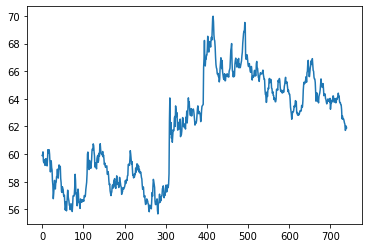

In [128]:
usd_rates.curs.plot()

In [0]:
money = usd_rates.curs

In [0]:
PAST = 5
FUTURE = 2

In [131]:
start = PAST
end = len(money) - FUTURE
count = len(money)
print(f"Всего у нас {count} значений USD по дням, мы рассмотрим дни с {start} по {end}")

Всего у нас 740 значений USD по дням, мы рассмотрим дни с 5 по 738


In [0]:
table = []
for i in range(start, end):
    s = money[(i-PAST):i+1]
    s = [s[i]-j for j in s][:-1]
    s += list(money[i:i+FUTURE])
    table.append(list(s))

In [133]:
past_columns = []
for i in range(PAST):
    past_columns.append(f"past_{PAST-i}")
past_columns.append(f"current")
past_columns

['past_5', 'past_4', 'past_3', 'past_2', 'past_1', 'current']

In [134]:
future_columns = []
for i in range(FUTURE):
    if i > 0:
      future_columns.append(f"future_{i}")
future_columns

['future_1']

In [0]:
df_course = pd.DataFrame(table, columns=(past_columns+future_columns))

In [136]:
df_course.head(3)

,past_5,past_4,past_3,past_2,past_1,current,future_1
0,-0.2894,-0.3466,-0.5547,0.1089,0.2367,59.6067,59.4015
1,-0.5518,-0.7599,-0.0963,0.0315,-0.2052,59.4015,59.1830
2,-0.9784,-0.3148,-0.1870,-0.4237,-0.2185,59.1830,59.3521


In [0]:
import numpy as np

In [0]:
X = df_course[past_columns][:-10]
Y = np.ravel(df_course[future_columns][:-10])

In [0]:
X_test = df_course[past_columns][-10:]
Y_test = np.ravel(df_course[future_columns][-10:])

In [140]:
from sklearn.neural_network import MLPRegressor
MLP = MLPRegressor(hidden_layer_sizes=(256,128), max_iter=2000, random_state=42)
MLP.fit(X,Y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(256, 128), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [142]:
errs_base = []
for i in range(10):
    prediction = MLP.predict([X_test.iloc[i]])
    err = mean_absolute_error([prediction[0]], [Y_test[i]])
    errs_base.append(prediction)
    print(f"Day #{i}, error = {err}")

Day #0, error = 0.2838264449241876
Day #1, error = 0.2668410500627232
Day #2, error = 0.07924632350241012
Day #3, error = 0.024323133538473485
Day #4, error = 0.08415196035422667
Day #5, error = 0.13447286342968567
Day #6, error = 0.050225919018473064
Day #7, error = 0.43812293981649475
Day #8, error = 0.10319057134329768
Day #9, error = 0.26112785412682626


In [0]:
df_cc = df_course.copy()
df_cc['predict'] = df_cc['current'] + (df_cc['past_1'] + df_cc['past_2'])/2

In [0]:
df_cc['delta'] = df_cc['future_1'] - df_cc['predict']

In [0]:
Y_predict_cc = df_cc[['predict','future_1','delta']][-10:]

In [146]:
Y_predict_cc

,predict,future_1,delta
723,61.71330,62.7686,1.05530
724,62.64715,62.5326,-0.11455
725,62.40370,62.5831,0.17940
726,62.51560,62.5283,0.01270
727,62.49875,62.4071,-0.09165
728,62.25850,62.2499,-0.00860
729,62.03210,62.1673,0.13520
730,62.00610,61.7164,-0.28970
731,61.22420,61.7676,0.54340
732,61.59335,62.0315,0.43815


In [0]:
Y_predict_cc['errs_base'] = errs_base

In [0]:
Y_predict_cc['short_predict'] = df_cc['current'] + 0.095*df_cc['past_1']

In [149]:
Y_predict_cc.head(3)

,predict,future_1,delta,errs_base,short_predict
723,61.71330,62.7686,1.05530,[62.48477355507581],62.490626
724,62.64715,62.5326,-0.11455,[62.799441050062725],62.788949
725,62.40370,62.5831,0.17940,[62.50385367649759],62.510180


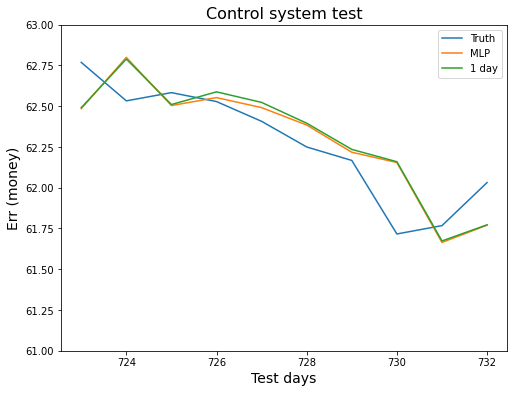

In [150]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Control system test", fontsize=16)
ax.set_xlabel("Test days", fontsize=14)        
ax.set_ylabel("Err (money)", fontsize=14)
ax.plot(Y_predict_cc['future_1'], label="Truth")
ax.plot(Y_predict_cc['errs_base'], label="MLP")
# ax.plot(Y_predict_cc['predict'], label="2 days med")
ax.plot(Y_predict_cc['short_predict'], label="1 day")
ax.legend()
plt.ylim(61, 63)
plt.show()